# Basic Usage

Below we will walk through how to use `lasertram` to process your data. Data used in this tutorial can be found in the `tests` folder:

`lasertram` is comprised of two classes:

1. `LaserTRAM`
2. `LaserCalc`

These two classes work in conjunction with one another and split up the data reduction process by having `LaserTRAM` deal with choosing ablation intervals and normalizing the data to an internal standard, while `LaserCalc` takes the output from `LaserTRAM` to calculate concentrations using the methodology described on the [Background](explanation.md) page.

We begin by loading in our data. The format required for `LaserTRAM` is a relatively simple on in that it has columns for:

- sample name: `SampleLabel`
- datetime of analysis: `timestamp`
- analyte counts per second values: these are specific to each experiment. Every row in the input data represents a full sweep through the mass range.


In [1]:
import lasertram
from lasertram import LaserTRAM, LaserCalc, batch, preprocessing, plotting
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt


# use a plotting style that comes shipped with lasertram for 
# better viewing of > 8 unique lines on a single figure
plt.style.use("lasertram.lasertram")
import warnings
warnings.filterwarnings('ignore')
print(f"lasertram {lasertram.__version__}")

lasertram 1.0.1


## Load in test data

Here we load in some data that comes shipped with lasertram. These data are analyses of volcanic tephra utilized in [Lubbers et al., (2023)](https://doi.org/10.1029/2023GC011037) and also the examples from [Lubbers et al., (2025)](https://doi.org/10.1016/j.acags.2025.100225).




In [2]:
raw_data = preprocessing.load_test_rawdata()
raw_data.head()

,timestamp,Time,7Li,29Si,31P,43Ca,45Sc,47Ti,51V,55Mn,...,153Eu,157Gd,163Dy,166Er,172Yb,178Hf,181Ta,208Pb,232Th,238U
SampleLabel,,,,,,,,,,,,,,,,,,,,,
GSD-1G_-_1,2022-05-10 23:08:59,13.24,100.0004,188916.876574,5901.392729,200.0016,1800.129609,0.0,300.0036,1500.090005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,379.06,0.0000,178769.261758,4600.846556,100.0004,800.025601,0.0,0.0000,1300.067604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,745.03,0.0000,182928.794765,6101.488763,100.0004,1000.040002,0.0,100.0004,1000.040002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,1110.96,0.0000,182319.996777,5701.299896,200.0016,1000.040002,0.0,0.0000,1400.078404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,1476.94,0.0000,175625.161124,5801.345912,100.0004,1300.067604,0.0,300.0036,1200.057603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


By setting the index to the `SampleLabel` column we can easily access all the information for one spot measurement and get a list of all possible spots in the experiment. Plotting up the data reveals a portion of the analysis in the middle that reflects ablated material being measured by the mass spectrometer and two background regions on either side.


In [3]:
samples = raw_data.index.unique().dropna().tolist()

# print the first five samples
print(samples[:5])


['GSD-1G_-_1', 'GSD-1G_-_2', 'GSE-1G_-_1', 'GSE-1G_-_2', 'BCR-2G_-_1']


Text(0.5, 0, 'Time (ms)')

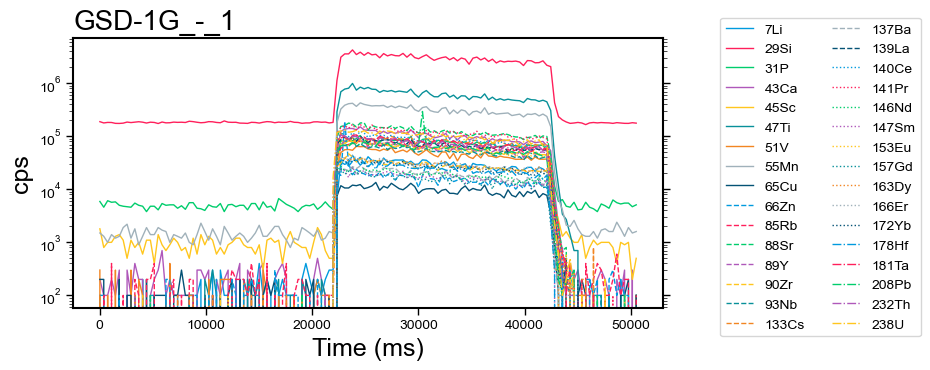

In [4]:
sample = "GSD-1G_-_1"
ax = plotting.plot_timeseries_data(raw_data.loc[sample,:])
ax[0].set_title(sample)
ax[0].set_ylabel("cps")
ax[0].set_xlabel("Time (ms)")

Now that we have confirmed that the data are in the right format and look correct we can begin processing with `LaserTRAM`! The first thing to do is to instantiate a `LaserTRAM` object and give it a name that reflects the material being ablated. For relatability we will call the object `spot` and assign the name attribute that of the `SampleLabel` column.


In [5]:
spot = LaserTRAM(name=sample)

spot.name

'GSD-1G_-_1'

Currently, the only information tied to our `LaserTRAM` object is the name of the spot analysis. To assign data to it we pass a dataframe to the `get_data()` method:


In [6]:
spot.get_data(raw_data.loc[sample, :])
spot.data.head()

,timestamp,Time,7Li,29Si,31P,43Ca,45Sc,47Ti,51V,55Mn,...,153Eu,157Gd,163Dy,166Er,172Yb,178Hf,181Ta,208Pb,232Th,238U
SampleLabel,,,,,,,,,,,,,,,,,,,,,
GSD-1G_-_1,2022-05-10 23:08:59,0.01324,100.0004,188916.876574,5901.392729,200.0016,1800.129609,0.0,300.0036,1500.090005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,0.37906,0.0000,178769.261758,4600.846556,100.0004,800.025601,0.0,0.0000,1300.067604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,0.74503,0.0000,182928.794765,6101.488763,100.0004,1000.040002,0.0,100.0004,1000.040002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,1.11096,0.0000,182319.996777,5701.299896,200.0016,1000.040002,0.0,0.0000,1400.078404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,1.47694,0.0000,175625.161124,5801.345912,100.0004,1300.067604,0.0,300.0036,1200.057603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The next step is to assign an internal standard analyte. All other analytes will be normalized to the values of the internal standard analyte. This helps mitigate differences in ablation yield across different materials (i.e., between unknowns and calibration standard reference materials). We then also assign regions of the analysis to be used as background and as the region that is used for calculating concentrations later on.


Text(0.5, 0, 'Time (ms)')

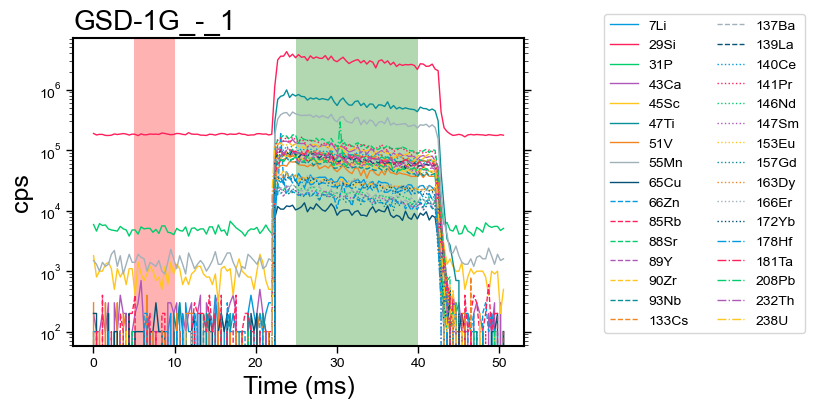

<Figure size 800x400 with 0 Axes>

In [7]:
bkgd_interval = (5, 10)
keep_interval = (25, 40)

spot.assign_int_std("29Si")
spot.assign_intervals(bkgd_interval, keep_interval)

fig, ax = plt.subplots(1,2, figsize = (8,4), width_ratios = [0.8,.2])
plotting.plot_timeseries_data(spot.data, ax=ax)
ax[0].axvspan(bkgd_interval[0], bkgd_interval[1], facecolor="r", alpha=0.3)
ax[0].axvspan(keep_interval[0], keep_interval[1], facecolor="g", alpha=0.3)
ax[0].set_title(sample)
ax[0].set_ylabel("cps")
ax[0].set_xlabel("Time (ms)")

With regions established for background and ablation area of interest as well as an internal standard analyte, we can go ahead and finish the `LaserTRAM` process by

- subtracting the median background signal from the area of interest
- establish detection limits
- normalize all analytes to the internal standard
- create an output report to be used later in `LaserCalc`


In [8]:
spot.get_bkgd_data()
spot.subtract_bkgd()
spot.get_detection_limits()
spot.normalize_interval()
spot.make_output_report()

All decisions made are recorded in the output report:

- timestamp: datetime format analysis time
- Spot: name of the analysis
- despiked: whether or not a despiking algorithm was done. If this was done values here will be a list of analytes that have been despiked
- bkgd_start, bkgd_stop: start and stop times for the portion of analysis that denotes background
- int_start, int_stop: start and stop times for the portion of the analysis that denotes signal to be turned into concentration
- norm: internal standard analyte
- norm_cps: the median counts per second of the internal standard over [int_start, int_stop)
- analyte values: Columns with analytes as headers represent the median normalized value for that analyte over [int_start, int_stop). Columns with the suffix \_se are the 1 standard error of the mean for that value.


In [9]:
# just transpose it so it's easier to read on screen
spot.output_report.T

,0
timestamp,2022-05-10 23:08:59
Spot,GSD-1G_-_1
despiked,None
omitted_region,None
bkgd_start,5.1363
...,...
178Hf_se,2.110963
181Ta_se,1.828765
208Pb_se,8.972243
232Th_se,1.846345


### LaserTRAM and iteration

While the above example is all well and good, concentrations can only be calculated if a whole suite of spots are processed together. Furthermore, we need standard reference materials interspersed throughout to help monitor for drift in the mass spectrometer. While proper experiment set up is beyond the scope of this tutorial, below we show how to iterate through a whole experiment and make an output that is ready for `LaserCalc`. This uses the same ablation interval for all spots, but this need not be the case as an array/list of tuples can also be iterated over such that it can be unique to every analysis. There are two ways to do this:

1. repeat all the above steps in a loop.
2. the `process_spot()` function. This is a function that essentially wraps around all the above steps to turn the processing into a one-liner.

The example below will show how to do option 2.


In [10]:
bkgd_interval = (5, 8)
keep_interval = (25, 40)

my_spots = []
for sample in samples:
    spot = LaserTRAM(name=sample)
    batch.process_spot(
        spot,
        raw_data=raw_data.loc[sample, :],
        bkgd=bkgd_interval,
        keep=keep_interval,
        int_std="29Si",
        despike=False,
        output_report=True,
    )
    my_spots.append(spot)

processed_df = pd.DataFrame()
for spot in my_spots:
    processed_df = pd.concat([processed_df, spot.output_report])

processed_df.head()

,timestamp,Spot,despiked,omitted_region,bkgd_start,bkgd_stop,int_start,int_stop,norm,norm_cps,...,153Eu_se,157Gd_se,163Dy_se,166Er_se,172Yb_se,178Hf_se,181Ta_se,208Pb_se,232Th_se,238U_se
0,2022-05-10 23:08:59,GSD-1G_-_1,None,None,5.13630,8.06369,25.26230,40.26601,29Si,2.819243e+06,...,1.807290,2.069928,1.736120,1.941916,1.853877,2.110963,1.828765,8.972243,1.846345,1.752916
0,2022-05-10 23:11:18,GSD-1G_-_2,None,None,5.13660,8.06392,25.26258,40.26633,29Si,2.719623e+06,...,1.662162,2.217590,1.724085,2.044176,1.693909,1.852447,1.701460,1.695180,1.760538,1.842550
0,2022-05-10 23:12:17,GSE-1G_-_1,None,None,5.13607,8.06338,25.26233,40.26580,29Si,2.722920e+06,...,1.393815,1.268197,1.220743,1.263343,1.198869,1.184812,1.150014,1.278186,1.209795,1.292956
0,2022-05-10 23:13:14,GSE-1G_-_2,None,None,5.13632,8.06392,25.26261,40.26579,29Si,2.766082e+06,...,1.738069,1.663282,1.791160,1.782537,1.925097,1.773096,1.705636,1.727455,1.635100,1.744791
0,2022-05-10 23:14:11,BCR-2G_-_1,None,None,5.13639,8.06384,25.26257,40.26566,29Si,2.768397e+06,...,3.152724,3.585669,2.914009,2.947615,3.297311,3.418897,4.871147,2.240678,1.831766,3.046107


## LaserCalc

With an entire experiment run through `LaserTRAM` much of the "hard" work and decision making has been done (i.e., you have some pesky analyses with heterogeneities you'd like to not include in your calculations) and we're ready for `LaserCalc`! Now seems like a good time to point back to the [Background](explanation.md) page for all the underlying maths that help govern these calculations. Similar to `LaserTRAM`, we begin the `LaserCalc` process by instantiating an object. Here we call it `concentrations` for relatability.


In [11]:
concentrations = LaserCalc(name="tutorial")
concentrations.name

'tutorial'

Critical in the `LaserCalc` process is a database of standard reference material (SRM) compositions. These are used as reference values for the calibration standard that we will choose later on. This can be found in the tests folder, however if there is an SRM you'd like to add, simply follow the format of the existing SRMs and append the new SRM to the bottom of the existing data


In [12]:
srm_data_path = Path(r"..") / "test_data"
srm_data = pd.read_excel(srm_data_path / "laicpms_stds_tidy.xlsx")
srm_data.head()

,Standard,Ag,Al,As,Au,B,Ba,Be,Bi,Br,...,SiO2_std,TiO2_std,Sl2O3_std,FeO_std,MgO_std,MnO_std,CaO_std,Na2O_std,K2O_std,P2O5_std
0,BCR-2G,0.5,70918.232337,NaN,NaN,6.0,683.0,2.300,0.050,NaN,...,4000,400.0,4000.0,3000.0,900.0,100.0,1100.0,700,400.0,100.0
1,BHVO-2G,NaN,71976.713416,NaN,NaN,NaN,131.0,1.300,0.010,NaN,...,1000,200.0,1000.0,1000.0,200.0,300.0,1000.0,1000,200.0,200.0
2,BIR-1G,NaN,82032.283673,NaN,NaN,NaN,6.5,0.100,0.009,NaN,...,3000,700.0,2000.0,1000.0,1000.0,100.0,2000.0,700,50.0,30.0
3,GSA-1G,1.6,72505.953956,0.51,0.9,23.0,57.8,0.085,0.070,NaN,...,5000,700.0,5000.0,2000.0,200.0,0.0,600.0,2000,2000.0,0.0
4,GSC-1G,4.1,71447.472876,3.20,6.0,26.0,34.8,4.500,3.400,NaN,...,6000,600.0,4000.0,1000.0,100.0,0.0,1000.0,2000,0.0,0.0


With SRM published values now loaded in we will assign them and the output from `LaserTRAM` to our `concentrations` object. It is important to load in the SRM data first as `LaserCalc` uses that to check your `LaserTRAM` output for potential standard reference materials (note it does this by name so name your analyses accordingly).


In [13]:
concentrations.get_SRM_comps(srm_data)
concentrations.get_data(processed_df)
concentrations.potential_calibration_standards

['ATHO-G', 'BCR-2G', 'GSD-1G', 'GSE-1G', 'NIST-612']

We can see that `LaserCalc` has identified 3 potential calibration standards. We can then assign the calibration standard to the `concentrations` object and then check for drift in the calibration standard over the duration of the experiment. More information on drift correction can be found on the [Background](explanation.md) page.


In [14]:
concentrations.set_calibration_standard("GSD-1G")
concentrations.drift_check()
concentrations.calibration_std_stats

,drift_correct,f_pval,f_value,f_crit_value,rmse,slope,intercept,mean,std_dev,percent_std_err
7Li,False,0.956513,0.003112,4.155258,1.691118e-04,-4.375066e-08,1.215213,0.010444,0.000176,0.467494
29Si,False,1.000000,-11.000000,4.155258,7.552352e-12,-6.505213e-19,1.000000,1.000000,0.000000,0.000000
31P,False,0.075861,3.840183,4.155258,3.081366e-04,-2.800332e-06,77.138557,0.025359,0.000373,0.407426
43Ca,False,0.229881,1.615942,4.155258,4.869743e-04,2.870841e-06,-79.018586,0.036246,0.000543,0.415349
45Sc,False,0.432208,0.664688,4.155258,2.588107e-04,9.785462e-07,-26.925750,0.020641,0.000277,0.372742
47Ti,False,0.127681,2.714485,4.155258,2.818122e-03,2.153247e-05,-592.727269,0.215923,0.003275,0.420691
51V,False,0.012887,8.784096,4.155258,2.681200e-04,3.685259e-06,-101.464982,0.016603,0.000374,0.625182
55Mn,False,0.624338,0.253815,4.155258,5.959639e-04,-1.392416e-06,38.453827,0.110646,0.000627,0.157270
65Cu,False,0.836231,0.044807,4.155258,8.471211e-05,8.315854e-08,-2.286629,0.003322,0.000088,0.737619
66Zn,False,0.426921,0.680561,4.155258,1.216077e-04,-4.652484e-07,12.816967,0.005345,0.000130,0.676838


The above DataFrame has just about all the statistics you'll need for your calibration standard and whether or not it will be drift corrected by `LaserCalc`. Remember from the [Background](explanation.md) page, that the regression here is with time as the independent variable and normalized ratio for each analyte as the independent variable and drift correction only happens if the regression is statistically significant (p value for the F statistic is below the threshold AND the F statistic is > F critical value)!


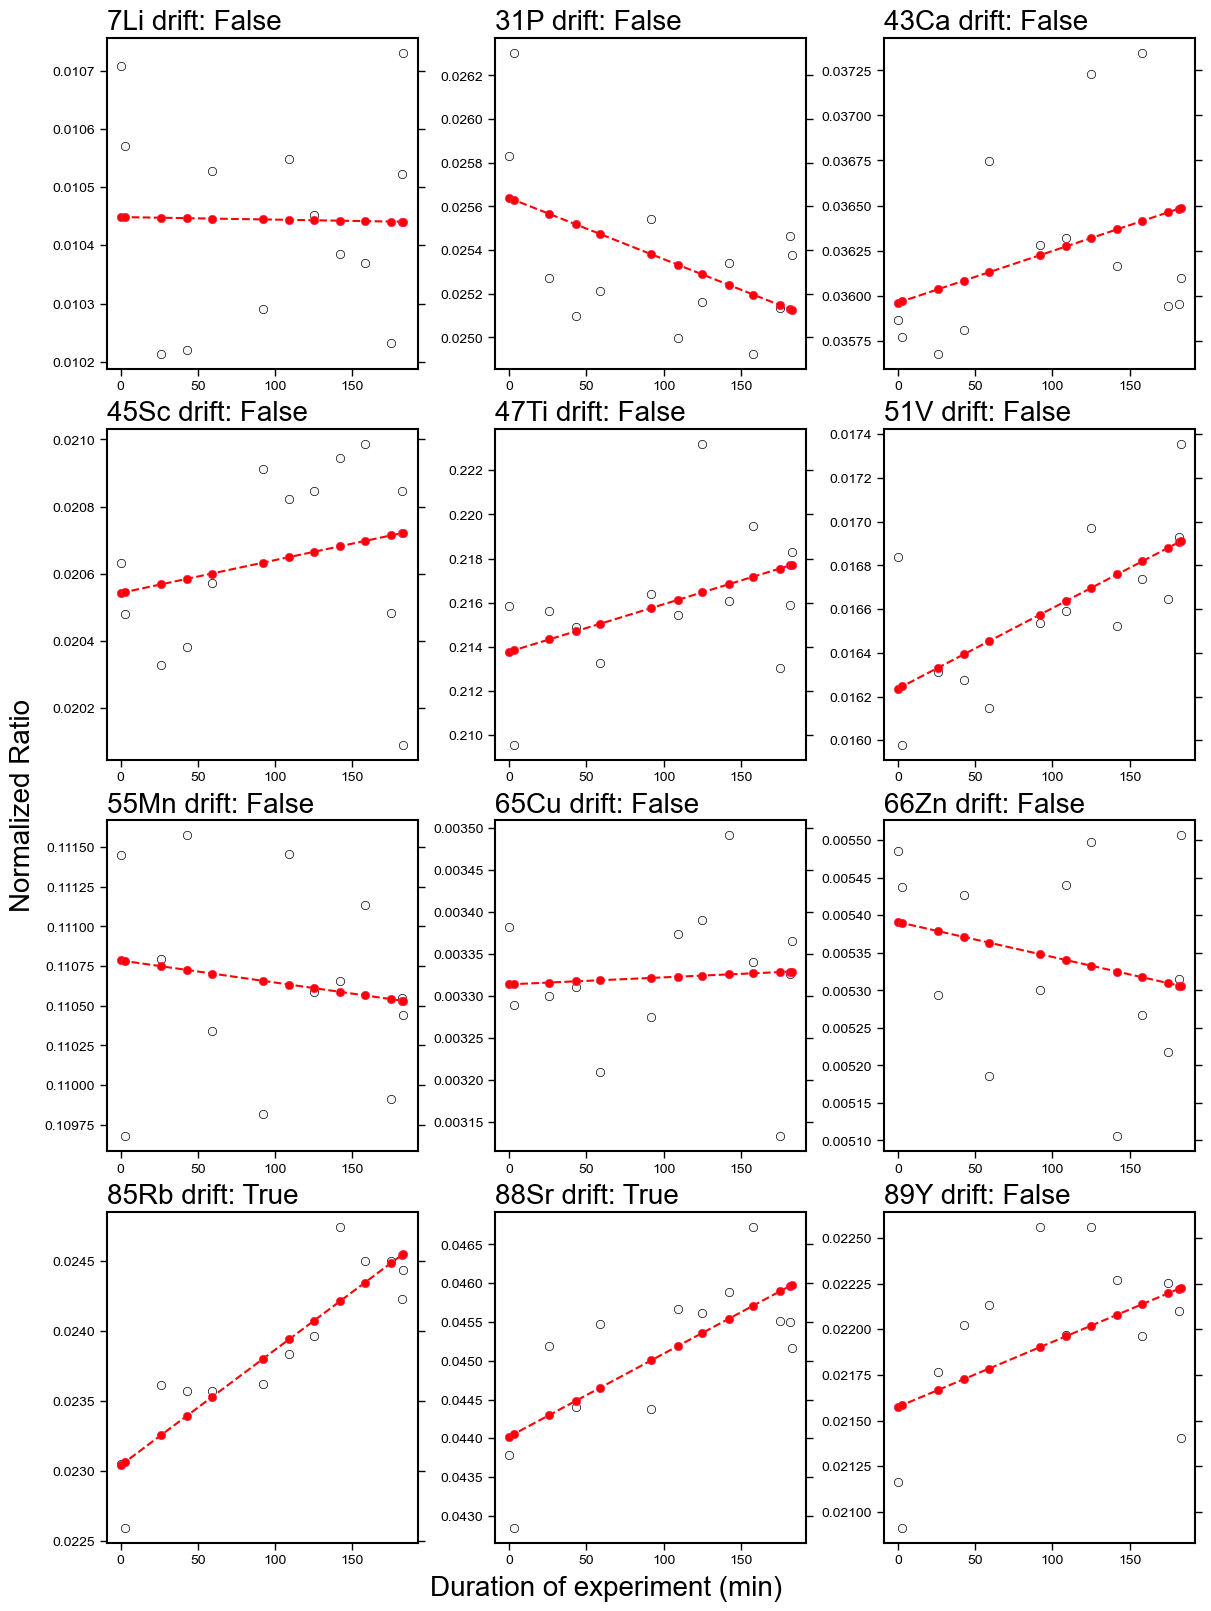

In [15]:
fig, ax = plt.subplots(4, 3, figsize=(12, 16), layout="constrained")
axes = ax.ravel()
plot_analytes = concentrations.analytes.copy()
plot_analytes.remove(concentrations.data["norm"].unique().tolist()[0])

for a, analyte in zip(axes, plot_analytes):
    x = np.array(
        [
            np.datetime64(d, "m")
            for d in concentrations.calibration_std_data["timestamp"]
        ]
    ).astype(np.float64)
    y = concentrations.calibration_std_data[analyte]
    a.plot(
        np.cumsum(np.diff(x, prepend=x[0])),
        y,
        marker="o",
        ls="",
        mec="k",
        mfc="whitesmoke",
    )

    Y = (
        concentrations.calibration_std_stats.loc[analyte, "slope"] * x
        + concentrations.calibration_std_stats.loc[analyte, "intercept"]
    )
    a.plot(np.cumsum(np.diff(x, prepend=x[0])), Y, ls="--", c="r")

    a.set_title(
        f"{analyte} drift: {concentrations.calibration_std_stats.loc[analyte,'drift_correct']}",
        loc="left",
    )

    fig.supxlabel("Duration of experiment (min)", fontsize=20)
    fig.supylabel("Normalized Ratio", fontsize=20)

Oof. Okay. Now that we've checked for drift we're ready to set the concentration of the internal standard for our unknown analyses. `LaserCalc` will fill these in for standard reference materials if they're in the uploaded SRM database, however it is up to the user to put in the correct concentration (in wt% oxide) for the internal standard element. Because we used `29Si` as our internal standard, this means we must input the concentration of our internal standard in wt% SiO2.

To do this we use the `set_internal_standard_concentrations()` method that takes arguments for which spots you want to assign values for, their concentrations, and their relative uncertainty in percent. Because we are working with some test data we can utilize the `preprocessing.load_test_int_std_comps()` function that will do this relatively easily, however with your own data this can easily come from another spreadsheet where samples are named similarly (e.g., EPMA data) - thanks relational database theory! You might have noticed that this does not have any internal standard composition data for our SRMs. Don't worry, `LaserCalc` will handle this for all SRMs with the correct value as it queries the `srm_data` DataFrame. Remember (again!), naming is important here!


In [16]:
internal_std_comps = preprocessing.load_test_int_std_comps()

concentrations.get_calibration_std_ratios()

concentrations.set_int_std_concentrations(
    internal_std_comps['Spot'],
    internal_std_comps['SiO2'],
    internal_std_comps['SiO2_std%']
)
concentrations.data.loc[concentrations.samples_nostandards, ["Spot", "int_std_comp", "int_std_rel_unc"]].head()

,Spot,int_std_comp,int_std_rel_unc
sample,,,
unknown,AT-3214-2_shard1_-_1,64.28,1.000000
unknown,AT-3214-2_shard1_-_2,64.28,1.000000
unknown,AT-3214-2_shard1_-_3,64.28,1.000000
unknown,AT-3214-2_shard2_-_1,63.51,0.254395
unknown,AT-3214-2_shard2_-_2,63.51,0.254395


Finally, we call the `calculate_concentrations()` method to calculate the concentrations and uncertainties for all unknowns and secondary standard reference materials!


In [17]:
concentrations.calculate_concentrations()
concentrations.unknown_concentrations.head()

,timestamp,Spot,7Li,29Si,31P,43Ca,45Sc,47Ti,51V,55Mn,...,153Eu_interr,157Gd_interr,163Dy_interr,166Er_interr,172Yb_interr,178Hf_interr,181Ta_interr,208Pb_interr,232Th_interr,238U_interr
sample,,,,,,,,,,,,,,,,,,,,,
unknown,2022-05-10 23:20:00,AT-3214-2_shard1_-_1,24.861187,300468.318826,1415.220951,25705.410159,24.885263,4756.434152,42.746247,1510.974107,...,0.090687,0.437972,0.475257,0.303699,0.235801,0.373824,0.034037,0.530184,0.200519,0.116218
unknown,2022-05-10 23:21:04,AT-3214-2_shard1_-_2,11.959063,300468.318826,1535.745342,29494.262173,19.837554,4505.232534,41.272285,1394.871617,...,0.069785,0.35187,0.248118,0.159295,0.185677,0.220023,0.024472,0.333731,0.141559,0.103574
unknown,2022-05-10 23:22:00,AT-3214-2_shard1_-_3,14.751437,300468.318826,1334.161735,35896.282939,29.834148,4367.627656,53.029593,1862.184234,...,0.071198,0.349404,0.315388,0.207126,0.173477,0.209888,0.02157,0.438305,0.124968,0.10183
unknown,2022-05-10 23:22:57,AT-3214-2_shard2_-_1,20.19699,296869.056139,1550.1286,21562.777045,19.426727,4731.438439,44.553564,1401.483884,...,0.070153,0.34367,0.277239,0.183591,0.158769,0.205583,0.031799,0.40243,0.180602,0.100589
unknown,2022-05-10 23:23:54,AT-3214-2_shard2_-_2,22.425806,296869.056139,1466.23812,29759.028863,43.310727,4772.716255,66.830021,2620.633002,...,0.108316,0.652238,0.567504,0.389929,0.385681,0.198023,0.028741,0.503196,0.252474,0.130084


In [18]:
concentrations.SRM_concentrations.head()

,timestamp,Spot,7Li,29Si,31P,43Ca,45Sc,47Ti,51V,55Mn,...,153Eu_interr,157Gd_interr,163Dy_interr,166Er_interr,172Yb_interr,178Hf_interr,181Ta_interr,208Pb_interr,232Th_interr,238U_interr
sample,,,,,,,,,,,,,,,,,,,,,
ATHO-G,2022-05-10 23:16:07,ATHO-G_-_1,28.767279,353403.141361,86.600883,12293.319737,13.455109,1480.448526,3.525333,848.918366,...,0.081407,0.549529,0.413637,0.234259,0.260193,0.315002,0.073144,0.163632,0.163872,0.081900
ATHO-G,2022-05-10 23:17:04,ATHO-G_-_2,29.451289,353403.141361,102.965565,12300.583088,12.900427,1487.579326,3.644848,841.930546,...,0.094352,0.507107,0.393242,0.263912,0.272922,0.385428,0.102156,0.142956,0.146106,0.086464
ATHO-G,2022-05-11 02:16:45,ATHO-G_-_3,27.968612,353403.141361,106.881931,12424.689575,13.113591,1512.050181,3.545412,830.213874,...,0.083437,0.562812,0.448364,0.297611,0.283246,0.404327,0.099166,0.157309,0.175519,0.080930
ATHO-G,2022-05-11 02:18:01,ATHO-G_-_4,28.915660,353403.141361,95.216849,12797.768761,12.801964,1508.419720,3.619778,843.184498,...,0.094087,0.462215,0.435911,0.267130,0.281781,0.436659,0.105366,0.175948,0.176651,0.091066
BCR-2G,2022-05-10 23:14:11,BCR-2G_-_1,8.864854,254300.673149,1362.609664,50265.288071,35.993328,12871.397344,431.723048,1612.981284,...,0.066081,0.280897,0.188281,0.116221,0.110143,0.166599,0.037216,0.270458,0.126719,0.066996


A bit on the values here. There are columns for:
- timestamp and spot name: these are for notekeeping
- Analytes: These are the concentrations of each element in parts per million. We choose to keep the header as the isotope being measured for notekeeping reasons. You can change this on your own if you wish. 
- columns with the suffix `_exterr`: This is the 1 standard deviation uncertainty on the concentration that _includes_ the uncertainty in the calibration standard. In the vast majority of use cases, you should use this value as it allows you to be comparable to data generated using other methodologies ( i.e, processing softwares, internal standards, calibration standards).
- columns with the suffix `_interr`: This is the 1 standard deviation uncertainty on the concentration that does not include the uncertainty in the calibration standard. This is suitable for comparing datasets that have all been processed using the same methodologies. 

Finally `LaserCalc` objects have a built in method, `get_secondary_standard_accuracies`, to easily check the accuracy of each secondary standard measurement to preferred GEOREM values. It outputs a dataframe of accuracy values where accuracy is:
$$ 100 * \frac{measured}{accepted}$$
and values are therefore in percent.


In [19]:
concentrations.get_secondary_standard_accuracies()
concentrations.SRM_accuracies.head()

,timestamp,Spot,7Li,29Si,31P,43Ca,45Sc,47Ti,51V,55Mn,...,153Eu,157Gd,163Dy,166Er,172Yb,178Hf,181Ta,208Pb,232Th,238U
sample,,,,,,,,,,,,,,,,,,,,,
ATHO-G,2022-05-10 23:16:07,ATHO-G_-_1,100.584890,100.0,79.381833,101.181253,192.215842,96.844556,90.161968,103.407867,...,95.762213,109.912866,104.757990,108.664515,103.797779,105.329815,91.696988,105.060440,100.933613,96.981505
ATHO-G,2022-05-10 23:17:04,ATHO-G_-_2,102.976536,100.0,94.382356,101.241034,184.291809,97.311023,93.218618,102.556672,...,100.973338,105.590181,109.006546,108.876090,95.228027,110.089012,94.753236,98.500643,103.129659,105.599695
ATHO-G,2022-05-11 02:16:45,ATHO-G_-_3,97.792351,100.0,97.972253,102.262504,187.337017,98.911800,90.675511,101.129449,...,108.466871,119.797468,109.824408,113.998275,102.708511,106.836746,97.123647,104.575391,109.942693,93.714013
ATHO-G,2022-05-11 02:18:01,ATHO-G_-_4,101.103706,100.0,87.279572,105.333165,182.885201,98.674311,92.577452,102.709417,...,106.980930,112.515701,111.396260,114.912805,105.675517,111.828132,100.826169,105.128353,109.829955,102.618023
BCR-2G,2022-05-10 23:14:11,BCR-2G_-_1,98.498376,100.0,84.393414,99.619251,109.070690,91.286506,101.581894,104.063309,...,102.625308,111.867798,95.814241,101.881606,95.533999,94.135738,96.375703,97.269083,97.753672,101.099361


To visualize this, we can use some nifty pandas/seaborn magic to transform our data to long format and then plot it using things like a stripplot:


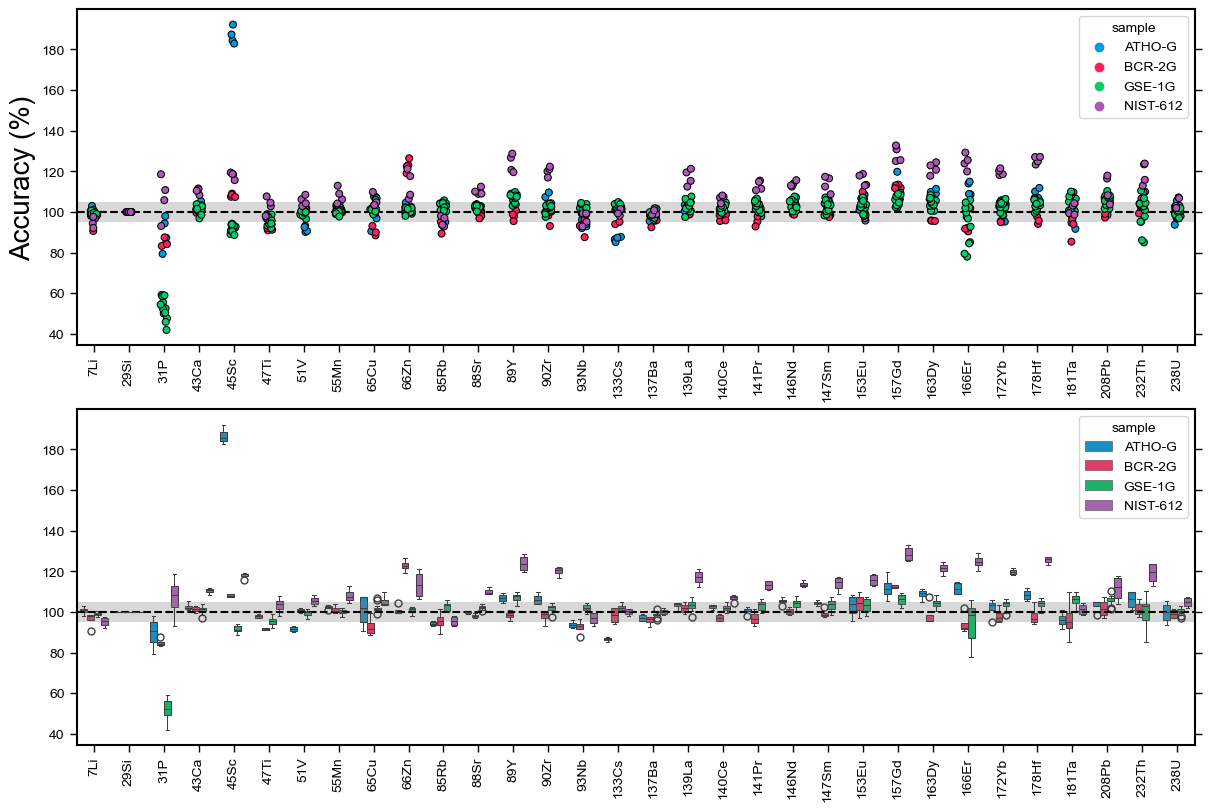

In [20]:
# convert to long format
melted_srm_accuracies = pd.melt(
    concentrations.SRM_accuracies.reset_index(),
    id_vars="sample",
    value_vars=concentrations.analytes,
)

# plot it up!
fig, ax = plt.subplots(2,1, figsize=(12, 8), layout="constrained")

sns.stripplot(
    data=melted_srm_accuracies.replace("b.d.l.",np.nan),
    x="variable",
    y="value",
    hue="sample",
    linewidth=0.75,
    edgecolor="k",
    ax=ax[0],
)
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_xlabel("")
ax[0].set_ylabel("Accuracy (%)", fontsize=20)

sns.boxplot(
    data=melted_srm_accuracies.replace("b.d.l.",np.nan),
    x="variable",
    y="value",
    hue="sample",
    linewidth=0.75,
    flierprops={"marker": "o", "mfc": "none"},
    ax=ax[1],
)
ax[1].set_xticks(ax[1].get_xticks())
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_xlabel("")
ax[1].set_ylabel("")

for a in ax:
    a.axhspan(95, 105, facecolor="gray", alpha=0.3)
    a.axhline(100, ls="--", color="k")
    # a.set_ylim(80, 120)

If we want overall sample statistics this is easily achieved with `pd.DataFrame.describe()`:


In [21]:
standard = "ATHO-G"

concentrations.SRM_accuracies.loc[standard, concentrations.analytes].describe()

,7Li,29Si,43Ca,45Sc,47Ti,51V,55Mn,65Cu,66Zn,85Rb,...,153Eu,157Gd,163Dy,166Er,172Yb,178Hf,181Ta,208Pb,232Th,238U
count,4.000000,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,100.614371,100.0,102.504489,186.682467,97.935423,91.658387,102.450851,100.605011,100.940127,94.338417,...,103.045838,111.954054,108.746301,111.612921,101.852459,108.520926,96.100010,103.316207,105.958980,99.728309
std,2.143513,0.0,1.949977,4.130422,1.013103,1.470183,0.955692,8.368864,2.476656,1.230136,...,5.837208,5.958185,2.837778,3.304668,4.583156,2.967387,3.855075,3.219804,4.622906,5.370919
min,97.792351,100.0,101.181253,182.885201,96.844556,90.161968,101.129449,90.557583,99.295850,93.054567,...,95.762213,105.590181,104.757990,108.664515,95.228027,105.329815,91.696988,98.500643,100.933613,93.714013
25%,99.886755,100.0,101.226089,183.940157,97.194406,90.547125,102.199866,95.283622,99.711676,93.444376,...,99.670557,108.832195,107.944407,108.823196,100.838390,106.460014,93.989174,103.056704,102.580647,96.164632
50%,100.844298,100.0,101.751769,185.814413,97.992667,91.626482,102.633045,102.176669,99.918328,94.306132,...,103.977134,111.214283,109.415477,111.437183,103.253145,108.462879,95.938441,104.817916,106.479807,99.799764
75%,101.571914,100.0,103.030169,188.556723,98.733683,92.737744,102.884030,107.498058,101.146779,95.200173,...,107.352415,114.336143,110.217371,114.226908,104.267214,110.523792,98.049277,105.077418,109.858139,103.363441
max,102.976536,100.0,105.333165,192.215842,98.911800,93.218618,103.407867,107.509123,104.628001,95.686835,...,108.466871,119.797468,111.396260,114.912805,105.675517,111.828132,100.826169,105.128353,109.942693,105.599695


The last thing to do is to export all our work to a single Excel sheet such that it can be shared easily. This can contain just about anything but we'll include the following:


In [22]:
out_path = Path(r"..") / "test_data"
with pd.ExcelWriter(
        out_path / f"lasercalc_example_export_{concentrations.calibration_std}.xlsx"
    ) as writer:
        concentrations.data.to_excel(writer, sheet_name="Raw")
        concentrations.standards_data.to_excel(writer, sheet_name="GEOREM")
        concentrations.calibration_std_data.to_excel(
            writer, sheet_name=f"{concentrations.calibration_std}_data"
        )
        concentrations.calibration_std_stats.to_excel(
            writer, sheet_name=f"{concentrations.calibration_std}_stats"
        )
        concentrations.SRM_concentrations.to_excel(
            writer, sheet_name="secondary SRM concentrations"
        )
        concentrations.SRM_accuracies.to_excel(
            writer, sheet_name="secondary SRM accuracies"
        )
        concentrations.unknown_concentrations.to_excel(
              writer, sheet_name = "unknown concentrations"
        )

print(f"your spreadsheet is saved at {out_path / f'lasercalc_example_export_{concentrations.calibration_std}.xlsx'}")

your spreadsheet is saved at ..\test_data\lasercalc_example_export_GSD-1G.xlsx
